In [7]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.linear_model import Lasso, Ridge

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

%matplotlib inline

# Prepare data

In [92]:
data = pd.read_csv("performance_year_financial_and_quality_results_puf_2020_01_01.csv")

In [93]:
#all of these are directly tied to the response variable and as such we do not want them as predictors
vars_to_exclude = ["EarnSaveLoss", "GenSaveLoss","BnchmkMinExp"] 
data_mod = data.drop(vars_to_exclude, axis=1)

#Drop non-relevant categorial columns
cat_cols_to_encode = ["Rev_Exp_Cat", "Risk_Model", "Agree_Type"]
cols = data_mod.columns
num_cols = data_mod._get_numeric_data().columns
vars_to_exclude = list(set(cols) - set(num_cols) - set(cat_cols_to_encode))
data_mod = data_mod.drop(vars_to_exclude, axis=1)

#one-hot encode relevant categorial columns
data_mod = pd.get_dummies(data_mod, columns=cat_cols_to_encode)

nans = ['DisAdj', 'PosRegAdj', 'Adv_Pay_Amt','Adv_Pay_Recoup']
data_mod = data_mod.drop(nans, axis=1)

X = data_mod.drop(['Sav_rate'], axis=1)
y = data_mod['Sav_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=34)

# Baseline Linear Regression

In [108]:
X_train_sm = sm.add_constant(X_train, prepend=True, has_constant='add')
model = sm.OLS(y_train, X_train_sm)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Sav_rate   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     123.3
Date:                Sat, 04 Dec 2021   Prob (F-statistic):          4.33e-197
Time:                        07:56:51   Log-Likelihood:                 1482.4
No. Observations:                 410   AIC:                            -2721.
Df Residuals:                     288   BIC:                            -2231.
Df Model:                         121                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.0024      0.013     -0.187      0.852      -0.028       0.023
Agreement_Period_Num        -3.168e-05      0.001     -0.027      0.979      -0.002       0.002
Current_Track_1                -0.0081      0.006     -1.285      0.200      -0.021       0.004
Current_Track_2                -0.0071      0.007     -0.982      0.327      -0.021       0.007
Current_Track_3                -0.0146      0.024     -0.611      0.542      -0.061       0.032
Current_Track_1_Plus            0.0155      0.011      1.417      0.157      -0.006       0.037
Current_BASIC_A                 0.0094      0.008      1.193      0.234      -0.006       0.025
Current_BASIC_B                 0.0060      0.008      0.777      0.438      -0.009       0.021
Current_BASIC_C                 0.0139      0.012      1.195      0.233      -0.009       0.037
Current_BASIC_D                -0.0086      0.016     -0.551      0.582      -0.039       0.022
Current_BASIC_E                 0.0135      0.011      1.194      0.234      -0.009       0.036
Current_ENHANCED               -0.0222      0.024     -0.923      0.357      -0.069       0.025
Adv_Pay                        -0.0003      0.003     -0.107      0.915      -0.007       0.006
AIM                             0.0044      0.003      1.670      0.096      -0.001       0.010
SNF_Waiver                     -0.0002      0.002     -0.110      0.912      -0.003       0.003
N_AB                           -0.0015      0.005     -0.300      0.765      -0.011       0.008
MinSavPerc                     -0.0418      0.071     -0.593      0.553      -0.181       0.097
DisAffQual                     -0.0024      0.013     -0.187      0.852      -0.028       0.023
Met_QPS                        -0.0024      0.013     -0.187      0.852      -0.028       0.023
QualScore                      -0.0002      0.001     -0.191      0.849      -0.002       0.002
RecvdMean                       0.0005      0.001      0.365      0.715      -0.002       0.003
RegTrndUpdt                    -0.0016      0.003     -0.473      0.637      -0.008       0.005
UpdatedBnchmk                8.619e-05   2.24e-06     38.412      0.000    8.18e-05    9.06e-05
HistBnchmk                  -1.004e-06    2.5e-06     -0.401      0.689   -5.93e-06    3.92e-06
ABtotBnchmk                  2.772e-10   9.26e-11      2.994      0.003    9.49e-11    4.59e-10
ABtotExp                    -2.974e-10   9.03e-11     -3.295      0.001   -4.75e-10    -1.2e-10
QualPerfShare                  -0.0127      0.015     -0.863      0.389      -0.041       0.016
FinalShareRate                  0.1442      0.151      0.952      0.342      -0.154       0.442
RevLossLimit                   -0.0025      0.006     -0.433      0.666      -0.014       0.009
Per_Capita_

In [109]:
#Print Coefficients with Significant P value

pvals = results.pvalues
coefs = results.params


results_df = pd.DataFrame({"coef": coefs, "P-value":pvals})
sig_coefs = results_df[results_df["P-value"] <= .05]
sig_coefs.sort_values(by = ['P-value'], inplace=True, axis=0)
sig_coefs

<ipython-input-109-7740a9d39c1a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_coefs.sort_values(by = ['P-value'], inplace=True, axis=0)


,coef,P-value
UpdatedBnchmk,8.619e-05,2.423e-115
Per_Capita_Exp_TOTAL_PY,-9.055e-05,8.821e-33
N_AB_Year_AGED_Dual_BY3,-2.055e-05,9.273e-12
Per_Capita_Exp_ALL_AGND_PY,1.068e-05,5.456e-06
Per_Capita_Exp_ALL_AGND_BY3,-5.597e-06,9.221e-04
ABtotExp,-2.974e-10,1.109e-03
N_AB_Year_DIS_BY3,7.372e-06,1.277e-03
Per_Capita_Exp_ALL_DIS_BY3,2.430e-06,1.929e-03
ABtotBnchmk,2.772e-10,2.996e-03
Per_Capita_Exp_ALL_AGDU_PY,-8.570e-07,7.422e-03


In [110]:
#Linear Regression with Cross Validation

lr = LinearRegression()

results = cross_validate(lr, X_train, y_train, cv=10, scoring = 'neg_mean_squared_error', return_train_score=True)
train_mse_lr = np.mean(-1*results['train_score'])
val_mse_lr = np.mean(-1*results['test_score'])
val_mse_stds_lr = np.std(-1*results['test_score'])
    
print(f"Mean training set MSE: {train_mse_lr:.7f}. Mean validation set MSE: {val_mse_lr:.7f} ")


#Overall Fitted Model
lr.fit(X_train, y_train)


Mean training set MSE: 0.0000389. Mean validation set MSE: 0.0003108 


LinearRegression()

# Scale Data for Lasso / Ridge

In [97]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lasso Linear Regression

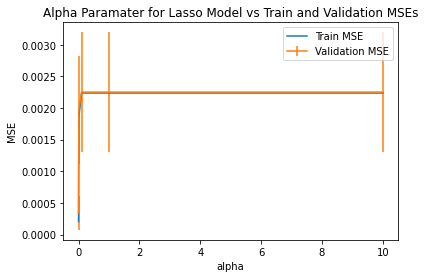

Alpha of Best Model: 0.001. Mean training set MSE: 0.0002043. Mean validation set MSE: 0.0003447 


Lasso(alpha=0.001, max_iter=10000)

In [98]:
%%capture --no-stdout --no-display

# your code here
train_MSEs = []
val_MSEs = []
val_MSEs_stds = []

alphas = [1e-3, 1e-2, 1e-1, 1e0, 1e1]

for alpha in alphas:    
    # Initialize a Lasso Linear Regression object
    lasso = Lasso(alpha = alpha, max_iter=10000)
    
    results = cross_validate(lasso, X_train_scaled, y_train, cv=10, scoring = 'neg_mean_squared_error', return_train_score=True)
    train_MSEs.append(np.mean(-1*results['train_score']))
    val_MSEs.append(np.mean(-1*results['test_score']))
    val_MSEs_stds.append(np.std(-1*results['test_score']))

plt.plot(alphas, train_MSEs, label="Train MSE")
plt.errorbar(alphas, val_MSEs, label="Validation MSE", yerr=val_MSEs_stds)
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.legend()
plt.title("Alpha Paramater for Lasso Model vs Train and Validation MSEs")
plt.show()

best_alpha_lasso = alphas[val_MSEs.index(min(val_MSEs))]
train_mse_lasso = train_MSEs[val_MSEs.index(min(val_MSEs))]
val_mse_lasso = min(val_MSEs)


print(f"Alpha of Best Model: {best_alpha_lasso}. Mean training set MSE: {train_mse_lasso:.7f}. Mean validation set MSE: {val_mse_lasso:.7f} ")


#Overall Fitted Model
lasso = Lasso(alpha = best_alpha_lasso, max_iter=10000)
lasso.fit(X_train_scaled, y_train)


In [99]:
#Print significant coefficients

cols = X_train.columns
coefs = lasso.coef_
print("Intercept: "+str(lasso.intercept_))
for i in range(0, len(coefs)):
    if abs(coefs[i]) > 1e-5:
        print(f"{cols[i]}: {coefs[i]:.5f}")

Intercept: 0.03791658536585361
Current_Track_1: -0.00124
Current_ENHANCED: 0.00067
AIM: 0.00043
MinSavPerc: -0.00029
UpdatedBnchmk: 0.11714
Per_Capita_Exp_ALL_ESRD_BY1: 0.00092
Per_Capita_Exp_ALL_AGDU_BY1: 0.00274
Per_Capita_Exp_ALL_ESRD_BY2: 0.00018
Per_Capita_Exp_ALL_ESRD_BY3: 0.00018
Per_Capita_Exp_ALL_DIS_BY3: 0.00012
Per_Capita_Exp_ALL_DIS_PY: -0.00126
Per_Capita_Exp_ALL_AGDU_PY: -0.00621
Per_Capita_Exp_ALL_AGND_PY: -0.00328
Per_Capita_Exp_TOTAL_PY: -0.11673
CMS_HCC_RiskScore_ESRD_BY1: 0.00104
CMS_HCC_RiskScore_ESRD_BY3: -0.00029
CMS_HCC_RiskScore_DIS_BY3: 0.00096
CMS_HCC_RiskScore_ESRD_PY: 0.00051
N_AB_Year_AGED_Dual_PY: 0.00029
N_Ben_Race_Asian: 0.00149
CapAnn_INP_S_trm: -0.00364
CapAnn_INP_Psych: 0.00030
CapAnn_HSP: -0.00007
CapAnn_OPD: -0.00022
CapAnn_DME: -0.00114
ADM_Rehab: -0.00045
ADM_Psych: 0.00105
P_CT_VIS: -0.00215
P_Nurse_Vis: 0.00424
Rev_Exp_Cat_High Revenue: -0.00293
Risk_Model_One-Sided: -0.00170
Agree_Type_Renewal: 0.00005


# Ridge Linear Regression

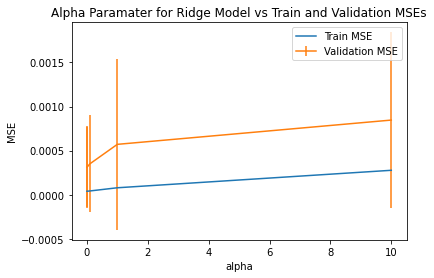

Alpha of Best Model: 0.001. Mean training set MSE: 0.0000397. Mean validation set MSE: 0.0003124 


Ridge(alpha=0.001, max_iter=10000)

In [100]:
%%capture --no-stdout --no-display

# your code here
train_MSEs = []
val_MSEs = []
val_MSEs_stds = []

alphas = [1e-3, 1e-2, 1e-1, 1e0, 1e1]

for alpha in alphas:    
    # Initialize a Ridge Linear Regression object
    ridge = Ridge(alpha = alpha, max_iter=10000)
    
    results = cross_validate(ridge, X_train_scaled, y_train, cv=10, scoring = 'neg_mean_squared_error', return_train_score=True)
    train_MSEs.append(np.mean(-1*results['train_score']))
    val_MSEs.append(np.mean(-1*results['test_score']))
    val_MSEs_stds.append(np.std(-1*results['test_score']))

plt.plot(alphas, train_MSEs, label="Train MSE")
plt.errorbar(alphas, val_MSEs, label="Validation MSE", yerr=val_MSEs_stds)
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.legend()
plt.title("Alpha Paramater for Ridge Model vs Train and Validation MSEs")
plt.show()

best_alpha_ridge = alphas[val_MSEs.index(min(val_MSEs))]
train_mse_ridge = train_MSEs[val_MSEs.index(min(val_MSEs))]
val_mse_ridge = min(val_MSEs)


print(f"Alpha of Best Model: {best_alpha_ridge}. Mean training set MSE: {train_mse_ridge:.7f}. Mean validation set MSE: {val_mse_ridge:.7f} ")

#Overall Fitted Model
ridge = Ridge(alpha = best_alpha_ridge, max_iter=10000)
ridge.fit(X_train_scaled, y_train)



In [101]:
#Print significant coefficients

cols = X_train.columns
coefs = ridge.coef_
print("Intercept: "+str(ridge.intercept_))
for i in range(0, len(coefs)):
    if abs(coefs[i]) > 1e-2:
        print(f"{cols[i]}: {coefs[i]:.5f}")

Intercept: 0.03791658536585357
UpdatedBnchmk: 0.19070
ABtotBnchmk: 0.06230
ABtotExp: -0.06328
FinalShareRate: 0.01674
Per_Capita_Exp_ALL_AGND_BY3: -0.01293
Per_Capita_Exp_ALL_AGND_PY: 0.02192
Per_Capita_Exp_TOTAL_PY: -0.20190
N_AB_Year_DIS_BY3: 0.01995
N_AB_Year_AGED_Dual_BY3: -0.03135
N_AB_Year_AGED_NonDual_BY3: 0.01008
N_AB_Year_PY: 0.01564
N_AB_Year_DIS_PY: -0.02164
N_AB_Year_AGED_Dual_PY: 0.03069
N_AB_Year_AGED_NonDual_PY: 0.02759
N_Ben_Age_75_84: -0.01378
CapAnn_INP_All: 0.03166
CapAnn_INP_S_trm: -0.03113
CapAnn_SNF: 0.01003
ADM: -0.05156
ADM_S_Trm: 0.04419
P_EM_Total: 0.02199
P_EM_PCP_Vis: -0.01287
P_EM_SP_Vis: -0.01022
P_FQHC_RHC_Vis: -0.01102


# Linear Model Summary

In [106]:
lm_df = pd.DataFrame({"Model":["Linear Regression", "Lasso Regression", "Ridge Regression"],
         "Mean Training MSE": [train_mse_lr, train_mse_lasso, train_mse_ridge ],
         "Mean Validation MSE": [val_mse_lr, val_mse_lasso, val_mse_ridge]
        })
lm_df.set_index("Model", inplace=True)

lm_df

,Mean Training MSE,Mean Validation MSE
Model,,
Linear Regression,3.886e-05,3.108e-04
Lasso Regression,2.043e-04,3.447e-04
Ridge Regression,3.966e-05,3.124e-04


In [112]:
print("Significant Coefficients from Linear Regression (ranked by p-value)")

sig_coefs

Significant Coefficients from Linear Regression (ranked by p-value)


,coef,P-value
UpdatedBnchmk,8.619e-05,2.423e-115
Per_Capita_Exp_TOTAL_PY,-9.055e-05,8.821e-33
N_AB_Year_AGED_Dual_BY3,-2.055e-05,9.273e-12
Per_Capita_Exp_ALL_AGND_PY,1.068e-05,5.456e-06
Per_Capita_Exp_ALL_AGND_BY3,-5.597e-06,9.221e-04
ABtotExp,-2.974e-10,1.109e-03
N_AB_Year_DIS_BY3,7.372e-06,1.277e-03
Per_Capita_Exp_ALL_DIS_BY3,2.430e-06,1.929e-03
ABtotBnchmk,2.772e-10,2.996e-03
Per_Capita_Exp_ALL_AGDU_PY,-8.570e-07,7.422e-03
